In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

In [3]:
nels_subset.columns[:100]

Index(['StudentId', 'Degree', 'InSchool12thGrade', 'Sex',
       'MaleGuardianOccupation', 'FemaleGuardianOccupation', 'Race',
       'ParentsHighestLevelEducation', 'HasMoreThan50Books',
       'HasSpecificPlaceForStudy', 'ReceivesNewspaper', 'FamilyHasComputer',
       'ParentsAttendedSchoolMeeting', 'ParentsSpokeWithCounselor',
       'ParentsCheckHomework', 'NoOneHomeWhenReturnFromSchool',
       'FathersWishes', 'MothersWishes', 'HoursWorkingForPayPerWeek',
       'SchoolWorkProblemsEighthGrade', 'TeachingIsGood',
       'TeachersInterestedInStudents', 'StudentDisruptions',
       'AcceleratedEnglish', 'AcceleratedHistory', 'AcceleratedScience',
       'AcceleratedMath', 'TimeSpentMath', 'TimeSpentScience',
       'TimeSpentEnglish', 'TimeSpentHistory', 'GradesMiddleSchoolEnglish',
       'GradesMiddleSchoolMath', 'GradesMiddleSchoolScience',
       'GradesMiddleSchoolHistory', 'PercentMinorityOfSchoolMiddleSchool',
       'PercentFreeLunchOfSchoolMiddleSchool',
       'Socio-econ

In [4]:
# Add 1st/2nd gen immigrant status 
# Native/non native english speaker

target_col = "GradesUndergrad" # Grades
nels_valid_grades = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Make binary decision >= 2.75 GPA
nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)

# Shuffle randomly before training models
nels_valid_grades = nels_valid_grades.sample(frac=1).reset_index(drop=True)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["Degree", 
"StudentId", 
"HighestPostSecondaryEducationAttained", 
"AttendedFirstChoicePostSecondaryEducation",
"JobSatisfaction", 
"Income",
"TotalEarningsJob1",
"TotalEarningsJob2",
"CoursesAt2To4YearCollege"]

nels_valid_grades = nels_valid_grades[nels_valid_grades.columns.difference(columns_to_withhold)]

X = nels_valid_grades[nels_valid_grades.columns.difference([target_col])]
y = nels_valid_grades[target_col]


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_6732/19572662.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)


In [5]:
# Run this cell to downsample
from sklearn.utils import resample
def resample_up_down(dataframe, upsample=True, target_col=target_col):
    # Separate majority and minority classes
    df_majority = dataframe[dataframe[target_col]==1]
    df_minority = dataframe[dataframe[target_col]==0]
    
    if upsample:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=0)
    
        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=0) 
        
        # Combine minority class with downsampled majority class
        df_resampled = pd.concat([df_majority_downsampled, df_minority])
        
    # Display new class counts
    print(df_resampled[target_col].value_counts())

    return df_resampled

nels_valid_grades = resample_up_down(nels_valid_grades, upsample=True, target_col=target_col)
X = nels_valid_grades.loc[:, nels_valid_grades.columns != target_col]
y = nels_valid_grades[target_col]           

1    6640
0    6640
Name: GradesUndergrad, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)


RandomForestClassifier()

In [8]:
predictions = rf.predict(x_test)

In [9]:
print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2039
           1       0.95      0.93      0.94      1945

    accuracy                           0.94      3984
   macro avg       0.94      0.94      0.94      3984
weighted avg       0.94      0.94      0.94      3984



In [10]:
rf_cross = RandomForestClassifier()
scores = cross_val_score(rf, X, y, cv=5)
scores

array([0.95519578, 0.95406627, 0.95858434, 0.95067771, 0.95707831])

/Users/lucasrosenblatt/opt/miniconda3/envs/fairness_aif/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


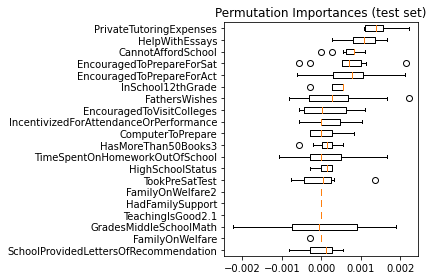

In [11]:
result = permutation_importance(
    rf, x_test, y_test, n_repeats=10, random_state=0, n_jobs=5, max_samples=1.0, scoring='f1'
)
sorted_idx = result.importances_mean.argsort()[-20:]

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


In [11]:
def return_real_column_name(human, human_list, yucky_list):
    return yucky_list[human_list.index(human)]

human_list = nels_columns_readable.columns.tolist()
yucky_list = nels_columns.columns.tolist()
return_real_column_name('Race', human_list, yucky_list)

'F4RACEM'

In [12]:
toy_columns = ['StudentId',
# .66 Acc RF
'Sex',
'Race',
'CompositeGrades',
'StandardizedTestQuartile',
'CategoricalGrades',

# .86 Acc RF (with base), .96 (second two), .58 (alone)
'TimeSpentOnHomeworkInSchool',
'TimeSpentOnHomeworkOutOfSchool',
'TimeSpentOnExtracurriculars',

# .92 Acc FR (with base), .82 (alone)
# 'HighSchoolHelpedWithSchoolApplication',
# 'HelpedWithFinancialAidApp',
# 'HelpWithEssays',
# 'ParentsHighestLevelEducation',
# 'Socio-economicStatusQuartile',
# 'PrivateSchoolExpenses',
# 'PrivateTutoringExpenses',
'Tutored',
'ParentsCheckHomework',
'FathersWishes',
# 'MothersWishes',

'GradesUndergrad']

In [13]:
# Only valid grades
toy_dataframe = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Only white/black nonhispanic
toy_dataframe = toy_dataframe[(3 <= toy_dataframe['Race']) & (toy_dataframe['Race'] <= 4)]

toy_dataframe = toy_dataframe[toy_columns]

# Make binary decision >= 2.75 GPA
toy_dataframe[target_col] = np.where(toy_dataframe[target_col] <= 3, 1, 0)

# Shuffle randomly before training models
toy_dataframe = toy_dataframe.sample(frac=1).reset_index(drop=True)

toy_dataframe = resample_up_down(toy_dataframe, upsample=True, target_col=target_col)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["StudentId"]

X = toy_dataframe[toy_dataframe.columns.difference([target_col]+columns_to_withhold)]
y = toy_dataframe[target_col]

1    5154
0    5154
Name: GradesUndergrad, dtype: int64


In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1048
           1       0.96      0.84      0.89      1014

    accuracy                           0.90      2062
   macro avg       0.91      0.90      0.90      2062
weighted avg       0.91      0.90      0.90      2062



In [19]:
from swap_auditor import NaiveSwapAuditor

tiny_test = toy_dataframe[:20]
new = NaiveSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
new.calculate_all_stability(marginal_features=['Tutored','ParentsCheckHomework','FathersWishes'])
print(new.individual_stability)

ind = 6819428
s, marg = new._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)

{6819428: (103, 126, {'Tutored': (18, 18), 'ParentsCheckHomework': (11, 18), 'FathersWishes': (18, 18), 'TutoredParentsCheckHomework': (14, 18), 'TutoredFathersWishes': (18, 18), 'ParentsCheckHomeworkFathersWishes': (11, 18), 'TutoredParentsCheckHomeworkFathersWishes': (13, 18)}), 6217702: (133, 133, {'Tutored': (19, 19), 'ParentsCheckHomework': (19, 19), 'FathersWishes': (19, 19), 'TutoredParentsCheckHomework': (19, 19), 'TutoredFathersWishes': (19, 19), 'ParentsCheckHomeworkFathersWishes': (19, 19), 'TutoredParentsCheckHomeworkFathersWishes': (19, 19)}), 7780736: (70, 70, {'Tutored': (10, 10), 'ParentsCheckHomework': (10, 10), 'FathersWishes': (10, 10), 'TutoredParentsCheckHomework': (10, 10), 'TutoredFathersWishes': (10, 10), 'ParentsCheckHomeworkFathersWishes': (10, 10), 'TutoredParentsCheckHomeworkFathersWishes': (10, 10)}), 7037799: (61, 70, {'Tutored': (10, 10), 'ParentsCheckHomework': (10, 10), 'FathersWishes': (9, 10), 'TutoredParentsCheckHomework': (10, 10), 'TutoredFathersWi

In [20]:
from swap_auditor import RandomizedSamplingSwapAuditor
randomized = RandomizedSamplingSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
randomized.calculate_all_stability(marginal_features=['Tutored','ParentsCheckHomework','FathersWishes'])
print(randomized.individual_stability)

ind = 6819428
s, marg = randomized._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)

Iterations: 600
{6819428: (3395, 4200, {'Tutored': (600, 600), 'ParentsCheckHomework': (341, 600), 'FathersWishes': (600, 600), 'TutoredParentsCheckHomework': (455, 600), 'TutoredFathersWishes': (600, 600), 'ParentsCheckHomeworkFathersWishes': (363, 600), 'TutoredParentsCheckHomeworkFathersWishes': (436, 600)}), 6217702: (4200, 4200, {'Tutored': (600, 600), 'ParentsCheckHomework': (600, 600), 'FathersWishes': (600, 600), 'TutoredParentsCheckHomework': (600, 600), 'TutoredFathersWishes': (600, 600), 'ParentsCheckHomeworkFathersWishes': (600, 600), 'TutoredParentsCheckHomeworkFathersWishes': (600, 600)}), 7780736: (4200, 4200, {'Tutored': (600, 600), 'ParentsCheckHomework': (600, 600), 'FathersWishes': (600, 600), 'TutoredParentsCheckHomework': (600, 600), 'TutoredFathersWishes': (600, 600), 'ParentsCheckHomeworkFathersWishes': (600, 600), 'TutoredParentsCheckHomeworkFathersWishes': (600, 600)}), 7037799: (3651, 4200, {'Tutored': (600, 600), 'ParentsCheckHomework': (600, 600), 'FathersWi

In [16]:
tiny_test

,StudentId,Sex,Race,CompositeGrades,StandardizedTestQuartile,CategoricalGrades,TimeSpentOnHomeworkInSchool,TimeSpentOnHomeworkOutOfSchool,TimeSpentOnExtracurriculars,Tutored,ParentsCheckHomework,FathersWishes,GradesUndergrad
0,6819428,2,3,2.5,1,99,0,1,2,-9,1,5,1
1,6217702,1,3,3.5,4,99,1,5,0,-9,2,6,1
2,7780736,2,4,2.8,9,99,2,3,5,-3,1,6,1
4,7037799,2,4,3.0,2,99,3,6,0,-3,1,5,1
5,6806027,1,4,3.8,9,99,99,99,99,-9,3,6,1
8,8452653,2,4,3.5,4,99,4,7,4,-9,3,5,1
11,5415765,2,4,3.8,4,99,1,3,1,-9,3,6,1
12,710660,2,4,3.0,2,99,1,2,0,-3,3,6,1
13,6851837,2,3,3.3,4,99,2,4,2,-9,1,98,1
14,4680316,2,4,3.5,4,99,2,6,4,-9,2,5,1
